# 영화 감상평 분석
- Naver sentiment movie corpus 데이터를 이용하여 사용자들의 영화 감상 평을 분류한다.
  - 레이블은 좋다/싫다 두개이고 id와 댓글을 사용한다.
- 3가지 모델 (Conv1D, LSTM, FCN)세가지 모델을 사용한다.
- pretrained되지 않은 모델의 embedding층에서 뽑은 word2vec과 pretrained된 word2vec을 이용하여 유사도 분석
- 사용했을때와 하지 아니하였을때 정확도를 분석한다.

# data loading

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# preprocessing data

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    # pad, bos, unk를 처리
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    print(word_to_index["<PAD>"])
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    


In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

0


In [4]:
word_to_index["영화"]

5

In [5]:
# word_to_index["<PAD"] = 0
# word_to_index["<BOS>"] = 1
# word_to_index["<UNK>"] = 2  # unknown
print(type(word_to_index))
print(word_to_index["<PAD>"])     # '<BOS>' 가 출력됩니다. 

<class 'dict'>
0


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## auto padding

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=100)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=100)

# modeling
- 모델은 우선 LSTM을 사용해 본다.

In [9]:
max_features = 10000

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# data split

In [10]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 100)
(136182,)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 96s 348ms/step - loss: 0.5213 - accuracy: 0.7397 - val_loss: 0.3387 - val_accuracy: 0.8529
Epoch 2/10
266/266 [==============================] - 92s 346ms/step - loss: 0.3225 - accuracy: 0.8640 - val_loss: 0.3284 - val_accuracy: 0.8553
Epoch 3/10
266/266 [==============================] - 92s 346ms/step - loss: 0.2926 - accuracy: 0.8773 - val_loss: 0.3223 - val_accuracy: 0.8612
Epoch 4/10
266/266 [==============================] - 93s 348ms/step - loss: 0.2643 - accuracy: 0.8889 - val_loss: 0.3227 - val_accuracy: 0.8620
Epoch 5/10
266/266 [==============================] - 93s 349ms/step - loss: 0.2404 - accuracy: 0.9010 - val_loss: 0.3280 - val_accuracy: 0.8632
Epoch 6/10
266/266 [==============================] - 93s 349ms/step - loss: 0.2214 - accuracy: 0.9109 - val_loss: 0.3414 - val_accuracy: 0.8639
Epoch 7/10
266/266 [==============================] - 93s 349ms/step - loss: 0.2050 - accuracy: 0.9171 - val_loss: 0.3559 - val_ac

In [12]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 50s - loss: 0.4118 - accuracy: 0.8535
[0.4118010401725769, 0.8534898161888123]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## loss, acc 그림 분석
- val loss는 학습중 증가하는 모습을 보이고 train셋은 꾸준히 감소한다.
- 그리하여 정확도는 val셋은 정확도가 제자리지만 train set은 증가한다.
- train 셋에 대하여 overfitting 되었다고 볼 수 있다.

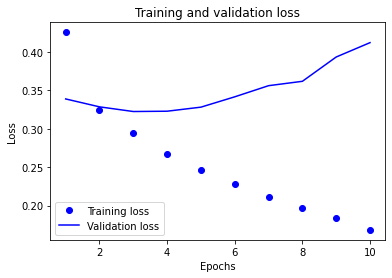

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

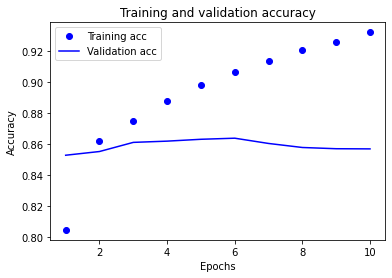

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## my embedding 분석
- 영화와 유사한 단어를 검색
- 좋지 못한 결과를 보여주는것 같다...

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [17]:
import os
vocab_size = 10000
word_vector_dim = 128
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [18]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec.txt'
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.00686562,  0.02387483,  0.01935211, -0.0438589 , -0.00124019,
       -0.02649513,  0.03119612,  0.04903575,  0.03781082, -0.00560815,
       -0.0468566 ,  0.01908606,  0.00755553, -0.02109006,  0.01473083,
       -0.00459838,  0.07839101, -0.00618635,  0.03767179, -0.0059484 ,
       -0.00240213,  0.05897483, -0.07935211, -0.09202827, -0.02797191,
       -0.05705218,  0.02586167,  0.08663707,  0.05428115,  0.0089411 ,
       -0.08223224, -0.00056332, -0.09370975,  0.05798167,  0.04171015,
       -0.01851384, -0.00854676, -0.00233983,  0.0254648 , -0.03961697,
       -0.00473338,  0.05505699,  0.05641931,  0.04575133, -0.01290398,
        0.04397247, -0.04535221,  0.05750536, -0.04765936, -0.01981114,
       -0.00281158, -0.03322125, -0.00365506,  0.02788787, -0.01612738,
       -0.00917774,  0.02612052,  0.00884153, -0.02828716,  0.01459732,
       -0.0075255 ,  0.01032899,  0.00251213,  0.03677225,  0.06156995,
        0.01073281,  0.02284284, -0.02172837,  0.01716655, -0.04

In [20]:
word_vectors.similar_by_word("영화")

[('점', 0.6276538372039795),
 ('ㅎ', 0.5221313238143921),
 ('...!', 0.5201687812805176),
 ('~~~!!!', 0.4957848787307739),
 ('날려', 0.4909258186817169),
 ('봐야겠다', 0.47906213998794556),
 ('교과서', 0.47631797194480896),
 ('남', 0.4734257161617279),
 ('준다', 0.47178351879119873),
 ('드립니다', 0.47099101543426514)]

# word2vec

- https://github.com/Kyubyong/wordvectors 에 있는 미리 학습된 word2vec를 가져와서 사용한다.

In [21]:
import gensim
word2vec_path = './data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)


- 확실히 my_word2vec과 달리 유사한 단어가 많이 나오는것을 볼 수 있다.

In [22]:
word2vec.similar_by_word("영화")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

## word2vec embedding layer 추가

In [23]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


## Conv1D layer model

In [24]:
from tensorflow.keras.initializers import Constant
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=100, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 16)            1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [25]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 20s 62ms/step - loss: 0.6496 - accuracy: 0.5970 - val_loss: 0.5389 - val_accuracy: 0.7170
Epoch 2/10
266/266 [==============================] - 13s 50ms/step - loss: 0.5027 - accuracy: 0.7447 - val_loss: 0.4845 - val_accuracy: 0.7526
Epoch 3/10
266/266 [==============================] - 13s 49ms/step - loss: 0.4438 - accuracy: 0.7805 - val_loss: 0.4696 - val_accuracy: 0.7616
Epoch 4/10
266/266 [==============================] - 13s 49ms/step - loss: 0.4102 - accuracy: 0.7988 - val_loss: 0.4617 - val_accuracy: 0.7690
Epoch 5/10
266/266 [==============================] - 13s 49ms/step - loss: 0.3829 - accuracy: 0.8141 - val_loss: 0.4638 - val_accuracy: 0.7673
Epoch 6/10
266/266 [==============================] - 13s 49ms/step - loss: 0.3582 - accuracy: 0.8278 - val_loss: 0.4740 - val_accuracy: 0.7627
Epoch 7/10
266/266 [==============================] - 13s 50ms/step - loss: 0.3372 - accuracy: 0.8390 - val_loss: 0.4820 - val_accuracy:

In [26]:
# 테스트셋을 통한 모델 평가
conv1_results = model.evaluate(X_test,  y_test, verbose=2)

print(conv1_results)

1537/1537 - 5s - loss: 0.5545 - accuracy: 0.7584
[0.5545306205749512, 0.7584067583084106]


In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


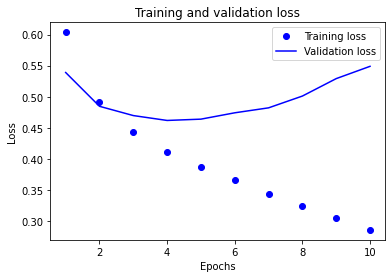

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

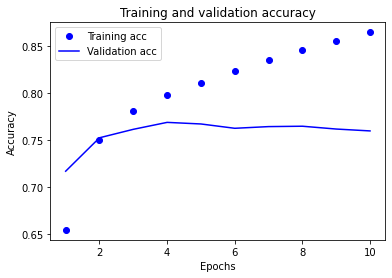

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## LSTM model

In [30]:
max_features = 10000

model = Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=100, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 101s 369ms/step - loss: 0.5382 - accuracy: 0.7152 - val_loss: 0.3600 - val_accuracy: 0.8408
Epoch 2/10
266/266 [==============================] - 97s 364ms/step - loss: 0.3586 - accuracy: 0.8411 - val_loss: 0.3237 - val_accuracy: 0.8616
Epoch 3/10
266/266 [==============================] - 95s 358ms/step - loss: 0.3164 - accuracy: 0.8627 - val_loss: 0.3157 - val_accuracy: 0.8654
Epoch 4/10
266/266 [==============================] - 95s 356ms/step - loss: 0.2884 - accuracy: 0.8783 - val_loss: 0.3119 - val_accuracy: 0.8716
Epoch 5/10
266/266 [==============================] - 94s 353ms/step - loss: 0.2688 - accuracy: 0.8869 - val_loss: 0.3051 - val_accuracy: 0.8718
Epoch 6/10
266/266 [==============================] - 94s 353ms/step - loss: 0.2513 - accuracy: 0.8958 - val_loss: 0.3131 - val_accuracy: 0.8727
Epoch 7/10
266/266 [==============================] - 94s 352ms/step - loss: 0.2364 - accuracy: 0.9018 - val_loss: 0.3076 - val_a

In [32]:
lstm_results = model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

1537/1537 - 55s - loss: 0.3499 - accuracy: 0.8679
[0.3499372899532318, 0.8679333329200745]


In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


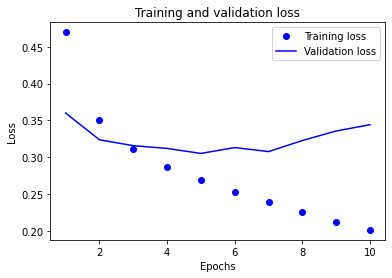

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

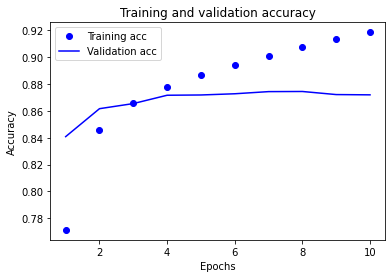

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## FCN layer model

In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [37]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 10s 34ms/step - loss: 0.5654 - accuracy: 0.7062 - val_loss: 0.3371 - val_accuracy: 0.8524
Epoch 2/10
266/266 [==============================] - 9s 34ms/step - loss: 0.3088 - accuracy: 0.8705 - val_loss: 0.3265 - val_accuracy: 0.8584
Epoch 3/10
266/266 [==============================] - 9s 34ms/step - loss: 0.2599 - accuracy: 0.8948 - val_loss: 0.3341 - val_accuracy: 0.8563
Epoch 4/10
266/266 [==============================] - 9s 34ms/step - loss: 0.2186 - accuracy: 0.9159 - val_loss: 0.3485 - val_accuracy: 0.8581
Epoch 5/10
266/266 [==============================] - 9s 34ms/step - loss: 0.1790 - accuracy: 0.9360 - val_loss: 0.3731 - val_accuracy: 0.8559
Epoch 6/10
266/266 [==============================] - 9s 34ms/step - loss: 0.1354 - accuracy: 0.9557 - val_loss: 0.4010 - val_accuracy: 0.8525
Epoch 7/10
266/266 [==============================] - 9s 33ms/step - loss: 0.0990 - accuracy: 0.9705 - val_loss: 0.4380 - val_accuracy: 0.852

In [38]:
fcn_results = model.evaluate(X_test,  y_test, verbose=2)

print(fcn_results)

1537/1537 - 3s - loss: 0.5788 - accuracy: 0.8410
[0.5787955522537231, 0.8409789204597473]


In [39]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


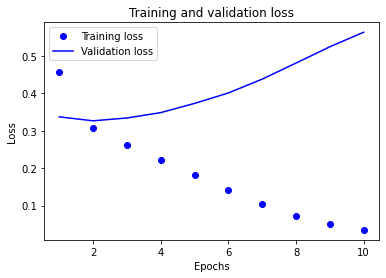

In [40]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

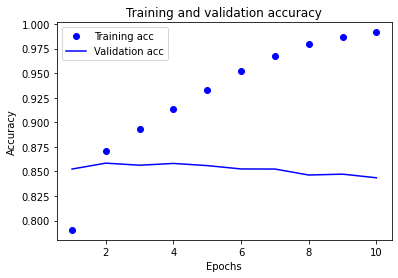

In [41]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 모델 비교
- 사용한 모델들의 test_set acc를 비교해 보았다.
- 유사한 가운데 pretrained된 word2vec를 사용한 LSTM이 가장 높은 성능을 보였다.

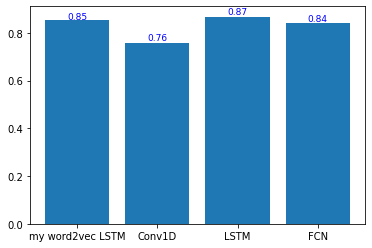

In [46]:
models = ['my word2vec LSTM', 'Conv1D', 'LSTM', 'FCN']
test_acc = [results[1], conv1_results[1], lstm_results[1], fcn_results[1]]
x = np.arange(4)
plt.bar(x, test_acc)
plt.xticks(x, models)

for i, v in enumerate(x):
    plt.text(v, round(test_acc[i],2), round(test_acc[i],2),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)


plt.show()